# K Means Clustering

In [44]:
# Importing all the required libraries
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [45]:
# Generating a personalized random seed
username = "prit.kanadiya"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
print(seed)

1379217023


### Implementing K Means Clustering Class

In [46]:
class KMeansClustering():
    def __init__(self, K, seed):
        '''
        Initializes the KMeansClustering object with the number of clusters (K) and the random seed

        Args:
            K (int): The number of clusters
            seed (int): The seed value for reproducibility
        '''
        self.K = K
        np.random.seed(seed)

    def fit(self, df, num_iters=50):
        '''
        Performs the K-means clustering algorithm on the given data

        Args:
            df (pd.DataFrame): The dataset to be clustered
            num_iters (int): The maximum number of iterations (default is 50)

        Returns:
            pd.DataFrame: The final centroid points of the clusters after fitting the K-means model
        '''
        data = df.copy()
        # Randomly assign K datapoints to be the means
        idx = np.random.choice(np.arange(len(data)), self.K)
        means = pd.DataFrame(columns=data.columns)

        # Initializing means
        for i in idx:
            means.loc[len(means)] = data.iloc[i]
        
        data["cluster"] = -1
        prev_means = pd.DataFrame()

        iters = 0
        while ((not means.equals(prev_means)) and (num_iters != iters)):
            prev_means = means.copy()
            iters += 1

            # E Step
            for idx, row in data.iterrows():
                min_dist = float("inf")
                min_idx = 0

                for i in range(self.K):
                    dist = (data.loc[idx, "Genre"] - means.loc[i, "Genre"])**2 + (data.loc[idx, "Age"] - means.loc[i, "Age"])**2 + (data.loc[idx, "Annual Income (k$)"] - means.loc[i, "Annual Income (k$)"])**2 + (data.loc[idx, "Spending Score (1-100)"] - means.loc[i, "Spending Score (1-100)"])**2
                    if (dist < min_dist):
                        min_dist = dist
                        min_idx = i
            
                data.loc[idx, "cluster"] = min_idx
                
            # M Step
            for i in range(self.K):
                cluster_data = data[data["cluster"] == i]
                cluster_data = cluster_data.drop(["cluster"], axis=1)
                means.loc[i] = cluster_data.mean()

            # print(f"Cost after iteration {iters}: {self.getCost(data, means)}")
        
        if (iters == num_iters):
            print("K Means failed to converge for given iterations.")
        
        self.means = means
        
        return means
    
    def predict(self, df):
        '''
        Predicts the cluster assignments for each data point based on the learned centroids

        Args:
            df (pd.DataFrame): The dataset to be predicted

        Returns:
            pd.Series: The cluster assignments for each data point
        '''
        data = df.copy()
        data["cluster"] = -1
        for idx, row in data.iterrows():
            min_dist = float("inf")
            min_idx = 0
            for i in range(self.K):
                dist = (data.loc[idx, "Genre"] - self.means.loc[i, "Genre"])**2 + (data.loc[idx, "Age"] - self.means.loc[i, "Age"])**2 + (data.loc[idx, "Annual Income (k$)"] - self.means.loc[i, "Annual Income (k$)"])**2 + (data.loc[idx, "Spending Score (1-100)"] - self.means.loc[i, "Spending Score (1-100)"])**2
                if (dist < min_dist):
                    min_dist = dist
                    min_idx = i
        
            data.loc[idx, "cluster"] = min_idx

        self.labels = data["cluster"]

        return data["cluster"]

    # The getCost method returns the within cluster sum of squares 
    def getCost(self, df, labels, means):
        '''
        Calculates the within-cluster sum of squares (WCSS)

        Args:
            df (pd.DataFrame): The dataset with data points and their assigned clusters
            labels (pd.Series): The cluster labels for each data point
            means (pd.DataFrame): The centroids of the clusters

        Returns:
            float: The total within-cluster sum of squares
        '''
        data = df.copy()
        data["cluster"] = labels

        # Calculating WCSS
        total_cost = 0
        for i in range(self.K):
            cluster = data[data["cluster"] == i]
            cluster_dist = 0
            for idx, row in cluster.iterrows():
                # dist = 0
                dist = (cluster.loc[idx, "Genre"] - means.loc[i, "Genre"])**2 + (cluster.loc[idx, "Age"] - means.loc[i, "Age"])**2 + (cluster.loc[idx, "Annual Income (k$)"] - means.loc[i, "Annual Income (k$)"])**2 + (cluster.loc[idx, "Spending Score (1-100)"] - means.loc[i, "Spending Score (1-100)"])**2
                cluster_dist += dist
                
            total_cost += cluster_dist

        return total_cost

In [47]:
customer_df = pd.read_csv("./data/Clustering_dataset.csv")
df = customer_df.copy()

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Genre                   194 non-null    object 
 2   Age                     194 non-null    float64
 3   Annual Income (k$)      194 non-null    float64
 4   Spending Score (1-100)  194 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.9+ KB
None
   CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  19.0                15.0                    39.0
1           2    Male  21.0                 NaN                    81.0
2           3  Female  20.0                16.0                     6.0
3           4  Female  23.0                16.0                    77.0
4           5  Female  31.0                17.0                    40.0


#### Data Preprocessing

In [48]:
# Performing data imputation for quantitative features
df["Age"] = df["Age"].fillna(int(df["Age"].median()))
df["Annual Income (k$)"] = df["Annual Income (k$)"].fillna(int(df["Annual Income (k$)"].median()))
df["Spending Score (1-100)"] = df["Spending Score (1-100)"].fillna(int(df["Spending Score (1-100)"].median()))

# Standardizing the quantitative features
df["Age"] = (df["Age"] - df["Age"].mean()) / df["Age"].std()
df["Annual Income (k$)"] = (df["Annual Income (k$)"] - df["Annual Income (k$)"].mean()) / df["Annual Income (k$)"].std()
df["Spending Score (1-100)"] = (df["Spending Score (1-100)"] - df["Spending Score (1-100)"].mean()) / df["Spending Score (1-100)"].std()

nan_indices_genre = df[df['Genre'].isna()].index
# print(f"Nan indices for Genre: {nan_indices_genre}")

# Performing KNN imputation for Genre
for nan_idx in nan_indices_genre:
    min_dist = float("inf")
    neighbor = 0
    for idx, row in df.iterrows():
        if (idx in nan_indices_genre):
            continue
        else:
            # Using euclidean distance
            dist = (df.loc[idx, "Age"] - df.loc[nan_idx, "Age"])**2 + (df.loc[idx, "Annual Income (k$)"] - df.loc[nan_idx, "Annual Income (k$)"])**2 + (df.loc[idx, "Spending Score (1-100)"] - df.loc[nan_idx, "Spending Score (1-100)"])**2
            if (min_dist > dist):
                min_dist = dist
                neighbor = idx
    
    df.loc[nan_idx, "Genre"] = df.loc[idx, "Genre"]

# Converting categorical value to quantitative
pd.set_option('future.no_silent_downcasting', True)
df["Genre"] = df["Genre"].replace({"Male": 0, "Female": 1})

# Dropping the CustomerID column
df = df.drop(["CustomerID"], axis=1)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genre                   200 non-null    object 
 1   Age                     200 non-null    float64
 2   Annual Income (k$)      200 non-null    float64
 3   Spending Score (1-100)  200 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.4+ KB
None
  Genre       Age  Annual Income (k$)  Spending Score (1-100)
0     0 -1.422451           -1.763819               -0.439899
1     0 -1.277672            0.044240                1.189358
2     1 -1.350062           -1.725350               -1.720030
3     1 -1.132894           -1.725350                1.034190
4     1 -0.553779           -1.686880               -0.401108


#### Applying K Means Clustering

In [49]:
# Initializing K Means Clustering Class
K = 3

kmeans = KMeansClustering(K, seed)
means = kmeans.fit(df)
labels = kmeans.predict(df)

In [50]:
print(means)

      Genre       Age Annual Income (k$) Spending Score (1-100)
0  0.555556 -0.378436           1.083767               0.994537
1  0.542857 -0.895043          -0.673488               0.130341
2  0.517647  0.937442          -0.019122              -0.633859


In [51]:
# Printing few points from each cluster

for i in range(K):
    indices = labels[labels == i].index
    cluster_df = customer_df.loc[indices]
    print("//////////////")
    print(f"Cluster {i} has total {len(cluster_df)} Members")
    print(cluster_df.head())

//////////////
Cluster 0 has total 45 Members
     CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
122         123  Female   NaN                69.0                    58.0
123         124    Male  39.0                69.0                    91.0
125         126  Female  31.0                70.0                    77.0
127         128    Male  40.0                71.0                    95.0
129         130    Male  38.0                71.0                    75.0
//////////////
Cluster 1 has total 70 Members
   CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  19.0                15.0                    39.0
1           2    Male  21.0                 NaN                    81.0
2           3  Female  20.0                16.0                     6.0
3           4  Female  23.0                16.0                    77.0
4           5  Female  31.0                17.0                    40.0
//////////////
Cluster 2 has tot

### Obtaining optimal value of K

#### Elbow Method

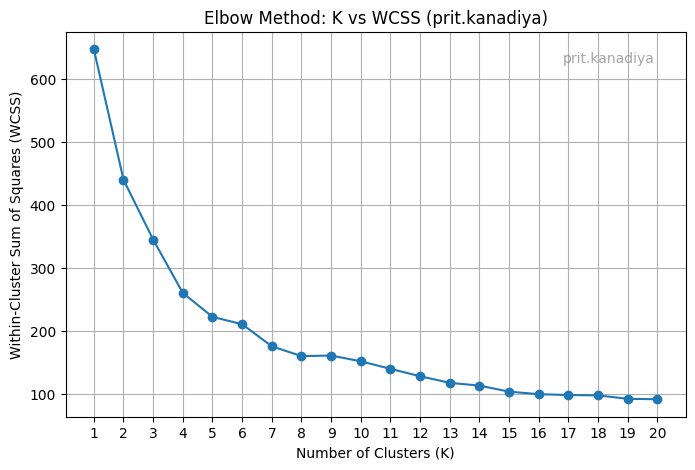

In [52]:
wcss_list = []

for K in range(1,21):
    kmeans = KMeansClustering(K, seed)
    means = kmeans.fit(df)
    labels = kmeans.predict(df)
    wcss = kmeans.getCost(df, labels, means)
    # print(f"WCSS at K = {K}: {wcss}")
    wcss_list.append(wcss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), wcss_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method: K vs WCSS (prit.kanadiya)')
plt.xticks(range(1, 21))
plt.grid(True)
plt.text(
        0.95, 0.95, "prit.kanadiya",
        ha = "right", va = "top",
        transform = plt.gca().transAxes,
        fontsize = 10, color = "gray", alpha=0.7
        )
plt.show()

Here, we can observe an elbow at `K = 7`. Hence, the optimal value of `K` using elbow method is `7`.

#### Silhouette Method

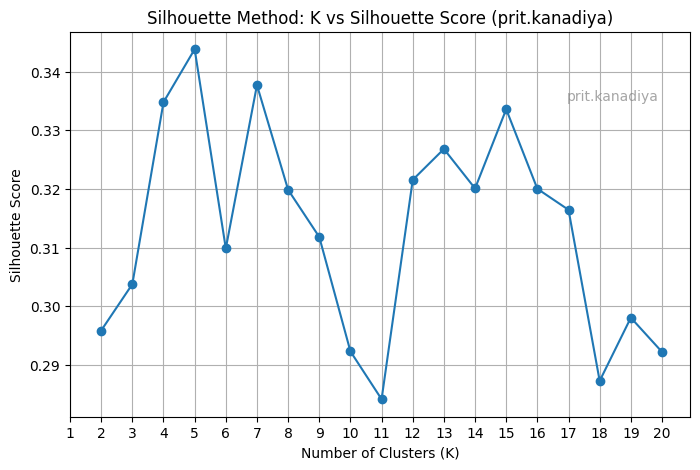

In [ ]:
# For silhouette score, we use sklearn library
silhouette_scores = [] = []

# Silhouette Score is not defined for K = 1
for K in range(2, 21):
    kmeans = KMeansClustering(K, seed)
    means = kmeans.fit(df)
    labels = kmeans.predict(df)
    silhouette = silhouette_score(df, labels)
    # print(f"Silhouette Score at K = {K}: {wcss}")
    silhouette_scores.append(silhouette)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method: K vs Silhouette Score (prit.kanadiya)')
plt.xticks(range(1, 21))
plt.grid(True)
plt.text(
        0.95, 0.85, "prit.kanadiya",
        ha = "right", va = "top",
        transform = plt.gca().transAxes,
        fontsize = 10, color = "gray", alpha=0.7
        )
plt.show()

For identifying the best K in silhouette method, we need to observe a peak value. Thus, the expectation is that the score will increase till a certain value of K, after which it will decrase. This turning point will act as optimal K. For our dataset, we observe a peak value at `K = 5`, and hence `5` is the optimal K using silhouette score.

In [54]:
# Printing few points from each cluster
K = 5

kmeans = KMeansClustering(K, seed)
means = kmeans.fit(df)
labels = kmeans.predict(df)

for i in range(K):
    indices = labels[labels == i].index
    cluster_df = customer_df.loc[indices]
    print("//////////////")
    print(f"Cluster {i} has total {len(cluster_df)} Members")
    print(cluster_df.head(10))

//////////////
Cluster 0 has total 40 Members
     CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
122         123  Female   NaN                69.0                    58.0
123         124    Male  39.0                69.0                    91.0
125         126  Female  31.0                70.0                    77.0
127         128    Male  40.0                71.0                    95.0
129         130    Male  38.0                71.0                    75.0
131         132    Male  39.0                71.0                    75.0
133         134  Female  31.0                72.0                    71.0
135         136  Female  29.0                73.0                    88.0
137         138    Male  32.0                73.0                    73.0
139         140  Female  35.0                74.0                    72.0
//////////////
Cluster 1 has total 58 Members
    CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
0            1    Mal

Cluster 0 primarily consists of young to middle-aged individuals with high annual income and high spending score. This group likely represents financially stable, high-value middle-aged customers who tend to spend more.

Cluster 1 consists of younger people with low income but medium to high spending score. Even this group represents a high value group but is financially unstable.

Cluster 2 includes old people with medium annual incomes and medium spending score. This cluster represents all the old people who are stable and normal buyers.

Cluster 3 represents middle aged people with high annual income but low spending score. This represents a group of customer who have ability to spend, but are not spending. One reason might be that they are not satisifed with the products or service.

Cluster 4 represents people with low annual income and low spending score. The age group here is mixed, and they represent the section which is more budget-oriented. Sale in this section can be improved if they are offered discounts or offers.